# MTH 9899 Homework 2
 
Stats calculation for the given stock data.
1. Calculate the turnover rate according to the instructions. Turnover rate is defined as the ratio of the total stocks adds and subtracts to the total stocks overnight over the total stocks at the previous day.
2. Compute and save corporate-action-adjusted daily returns for the given stock data. Store a file-per-day, similar to the files provided, with returns included for all names present in the universe on the day. If a stock doesn't have a price on the prior day, include it in the return data with a return of 0.
3. Compute and save a daily series of returns for a synthetic index by computing a MDV_63 weighted average return from all names in the universe on any given day. We’ll call this return series the “market return” series.
4. Compute and save a daily series of return for a synthetic index by computing a MDV_63 weighted average return from all names in the universe on any given day. We’ll call this return series the “market return” series.

@author Xuebin(Alston) Gui

In [3]:
# load library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# load data
df = pd.read_csv('hw2.csv')


## Task 1 
the universe of stock is not static, you should expect names to drop out of and enter the universe. Definig turnover as the # of adds and the # of drops from a day to the next, as percentage of the previous day universe size, what's the average turnover rate? what's the maximum? Plot this time series.

In [4]:
# iteration is not efficient, but it is easy to understand

def get_turnover_rate(df):

    turnover_rate_ts = []
    date_list = sorted(df['Date'].unique())
    # initialize the past_ticker_universe as the first day ticker universe
    # as SYMBOL is not guaranteed to be unique, we use ID gere
    past_ticker_universe = df[df['Date'] == date_list[0]]['ID']


    for i in range(1,len(date_list)):# start from the second day

        date = date_list[i]
        current_ticker_universe = df[df['Date'] == date]['ID'].unique()
        # turnover is the number of tickers that are not in both of them, so we use setxor1d
        tick_turnover = np.setxor1d(past_ticker_universe, current_ticker_universe)

        turnover_rate = (len(tick_turnover)) / len(past_ticker_universe)
        turnover_rate_ts.append([date, turnover_rate])

        past_ticker_universe = current_ticker_universe # update the past_ticker_universe
    return turnover_rate_ts
            

In [5]:
turn_over_ts = get_turnover_rate(df)
turn_over_df = pd.DataFrame(turn_over_ts, columns = ['Date', 'Turnover Rate'])

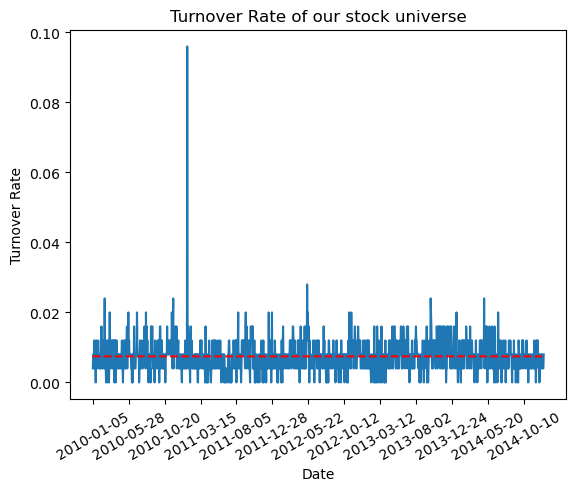

In [6]:
# plot the turnover rate
plt.plot(turn_over_df['Date'], turn_over_df['Turnover Rate'])
plt.plot(np.mean(turn_over_df['Turnover Rate'])*np.ones(len(turn_over_df['Date'])), 'r--')
plt.xticks(turn_over_df['Date'][::100], rotation=30)
plt.xlabel('Date')
plt.ylabel('Turnover Rate')
plt.title('Turnover Rate of our stock universe')
plt.show()

In [7]:
display(turn_over_df['Turnover Rate'].describe())

count    1257.000000
mean        0.007443
std         0.005008
min         0.000000
25%         0.004000
50%         0.008000
75%         0.008000
max         0.096000
Name: Turnover Rate, dtype: float64

In [8]:
print("--------------------------------------------")
print("Task 1 answer:")
print("The average turnover rate per day is: %.2f percentage"%(100*np.mean(turn_over_df['Turnover Rate'])))
print("The maximum turnover rate per day is: %.2f percentage"%(100*np.max(turn_over_df['Turnover Rate'])))
print("--------------------------------------------")

--------------------------------------------
Task 1 answer:
The average turnover rate per day is: 0.74 percentage
The maximum turnover rate per day is: 9.60 percentage
--------------------------------------------


## Task 2
Compute and save corporate-action-adjusted daily returns for the given stock data. Store a file-per-day, similar to the files provided, with returns included for all names present in the universe on the day. If a stock doesn't have a price on the prior day, include it in the return data with a return of 0.

In [9]:
# as the homework doesn't specify the return calculation method, we use the simple close to close return here.

# auxiliary function to conduct the price adjustment and volume adjustment

def price_adjust(df):
    price_col = ['Open', 'High', 'Low', 'Close']
    # one question here is that should we also adjust MDV_63
    # which is the median of the last 63 days volume in dollars
    # as it's price related, we should adjust it with the adjust factor of the exact day of the median
    # which is not the same as the adjust factor of the current day
    # so we don't adjust it here
    for col in price_col:
        df[col+"_Adj"] = df[col] * df['PxAdjFactor']
    df.drop(price_col, axis = 1, inplace = True)

    return df

def volume_adjust(df):
    df['Volume_Adj'] = df['Volume'] * df['SharesAdjFactor']
    df.drop(['Volume'], axis = 1, inplace = True)
    return df

def hard_copy(df):
    return df.copy()

def get_daily_return(df):
    df['Return'] = df.groupby('ID')['Close_Adj'].pct_change()
    df['Return'].fillna(0, inplace = True)
    return df

def column_selection(df, col_name):
    return df[['Date', 'ID', col_name]]
    

In [10]:
df_adj_ret = df.pipe(hard_copy).pipe(price_adjust).pipe(volume_adjust).pipe(get_daily_return).pipe(column_selection, 'Return')

In [11]:
# output the result into separate csv file
# name should be dat.YYYYMMDD.csv
output_folder = "hw2_task2"
for date in df_adj_ret['Date'].unique():
    df_adj_ret[df_adj_ret['Date']==date].to_csv(output_folder + "/dat." + str(date).replace("-","") + ".csv", index = False)

## Task 3 
Compute and save a daily series of returns for a synthetic index by computing a MDV_63 weighted average return from all names in the universe on any given day. We’ll call this return series the “market return” series.

In [12]:
df_adj = df.pipe(hard_copy).pipe(price_adjust).pipe(volume_adjust).pipe(get_daily_return)

In [13]:
# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=df.loc[x.index, "MDV_63"])
market_ret = df_adj.groupby(["Date"]).agg(market_ret=("Return", wm)).reset_index()

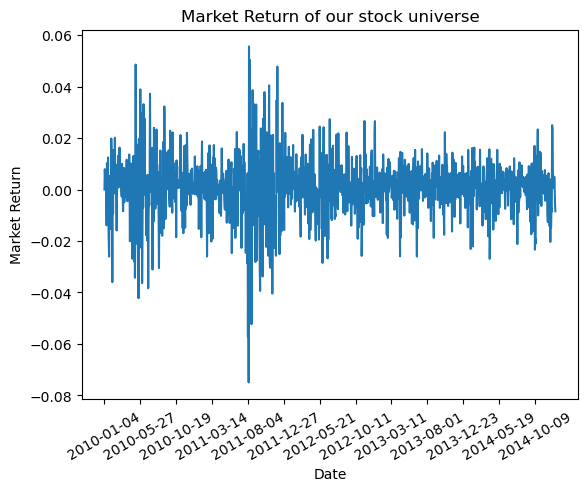

In [14]:
# plot the market return
plt.plot(market_ret['Date'], market_ret['market_ret'])
plt.xticks(market_ret['Date'][::100], rotation=30)
plt.xlabel('Date')
plt.ylabel('Market Return')
plt.title('Market Return of our stock universe')
plt.show()

In [15]:
output_folder = "hw2_task3"
market_ret.to_csv(output_folder + "/market_return.csv", index = False)

## Task 4
Compute and store 5 sets of betas, one for each year, by running a CAPM-style time-series regression (with an intercept) within each year, using the union of all names across daily universes in that year.



In [16]:
def merge_market_ret(df,market_df):
    df = df.merge(market_df, on = 'Date', how = 'left')
    return df


In [17]:
df_adj = df_adj.pipe(hard_copy).pipe(merge_market_ret, market_ret)

In [18]:
df_adj

,Date,ID,SYMBOL,MIC,FREE_FLOAT_PERCENTAGE,EST_VOL,MDV_63,PxAdjFactor,SharesAdjFactor,Open_Adj,High_Adj,Low_Adj,Close_Adj,Volume_Adj,Return,market_ret
0,2010-01-04,BBG000B9WH86,AA,XNYS,99.7169,0.17017,3.920905e+08,1.059996,1.0,17.458141,17.903339,17.383941,17.648940,25872368.0,0.000000,0.00000
1,2010-01-04,BBG000B9WJ73,ACI,XNYS,99.6263,0.15981,9.449197e+07,1.032174,1.0,23.316806,24.245763,23.265197,24.235441,3938765.0,0.000000,0.00000
2,2010-01-04,BBG000B9XRY4,AAPL,XNGS,99.2587,0.17121,3.221198e+09,1.000000,1.0,213.430000,214.500000,212.380000,214.010000,17540156.0,0.000000,0.00000
3,2010-01-04,BBG000B9XYV2,AMT,XNYS,99.9300,0.10602,1.030392e+08,1.000000,1.0,43.490000,43.890000,43.280000,43.460000,2750483.0,0.000000,0.00000
4,2010-01-04,BBG000B9YJ35,APH,XNYS,99.8885,0.15031,5.032276e+07,1.003591,1.0,47.178827,47.178827,46.074877,46.104984,1228549.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628995,2014-12-31,BBG002S5ZRF9,SSYS,XNGS,87.5651,0.28072,1.313357e+08,1.000000,1.0,81.920000,83.919000,80.540000,83.110000,1632145.0,0.018006,-0.00846
628996,2014-12-31,BBG002W96FT9,GOOG,XNGS,84.8225,0.14325,9.683617e+08,1.000000,1.0,531.250000,532.600000,525.800000,526.400000,1367110.0,-0.007579,-0.00846
628997,2014-12-31,BBG0039320N9,ZTS,XNYS,99.9858,0.19312,1.575936e+08,1.015131,1.0,44.117593,44.543948,43.650633,43.681087,2148909.0,-0.007382,-0.00846
628998,2014-12-31,BBG005P7Q881,AAL,XNGS,99.0796,0.12919,5.771311e+08,1.005051,1.0,54.172265,54.916003,53.589335,53.900901,11062437.0,0.003931,-0.00846


In [19]:
# CAPM for each year for each ID

def get_capm(df):
    df['Date'] = pd.to_datetime(df['Date'])
    for year in df['Date'].dt.year.unique():
        df_year = df[df['Date'].dt.year == year]
        for ID in df_year['ID'].unique():
            df_ID = df_year[df_year['ID'] == ID]
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_ID['market_ret'], df_ID['Return'])
            df.loc[df_ID.index, 'CAPM_beta'] = slope
    return df

In [20]:
df_capm = df_adj.pipe(hard_copy).pipe(get_capm).pipe(column_selection, 'CAPM_beta')

/Users/guixuebin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/guixuebin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/guixuebin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [21]:
df_capm.head(2)

,Date,ID,CAPM_beta
0,2010-01-04,BBG000B9WH86,1.390300
1,2010-01-04,BBG000B9WJ73,1.764465


In [23]:
df_capm.to_csv("hw2_task4.csv", index = False)